This is an adaptation of the [Holt-Winters with Python](https://docs.timescale.com/latest/tutorials/tutorial-forecasting#tutorial-python) example for TimescaleDB using the [Prometheus SQL adapter](https://github.com/ssube/prometheus-sql-adapter) schema as a data source.

In [29]:
import matplotlib.pyplot as plot
import numpy as np
import os
import pandas as pd
import pandas.io.json as pj
import psycopg2
from statsmodels.tsa.api import ExponentialSmoothing

def rgba(value, alpha=0.5):
    value = value.lstrip('#')
    lv = len(value)
    chans = [int(value[i:i+2], 16) / 256.0 for i in (0, 2, 4)]
    chans.append(alpha)
    return chans

In [30]:
conn = psycopg2.connect(os.environ.get('PROMSQL_CONNSTR'))
samples = pd.read_sql_query("""
SELECT 
    s.bucket AS time, 
    MAX(s.max_load) AS value, 
    REGEXP_REPLACE(l.labels->>'instance', '\d+\.\d+\.\d+\.', 'xxx.yyy.zzz.') AS instance 
FROM agg_instance_load AS s
JOIN metric_labels AS l 
    ON s.lid = l.lid
WHERE s.bucket > NOW() - INTERVAL '14 days'
GROUP BY s.bucket, instance
ORDER BY s.bucket, instance
""", conn)
conn.close()

In [31]:
print(samples.head(5))

                 time  value              instance
0 2019-12-10 12:00:00   1.65  xxx.yyy.zzz.158:9100
1 2019-12-10 12:00:00   1.57  xxx.yyy.zzz.163:9100
2 2019-12-10 12:00:00   0.39  xxx.yyy.zzz.164:9100
3 2019-12-10 12:00:00   1.19  xxx.yyy.zzz.180:9100
4 2019-12-10 12:00:00   0.51  xxx.yyy.zzz.192:9100


In [32]:
nodes = samples[['instance']].replace(r':\d+', '', regex=True)
load = samples.drop(columns=['instance']).join(nodes)

In [33]:
print(load.head(5))

                 time  value         instance
0 2019-12-10 12:00:00   1.65  xxx.yyy.zzz.158
1 2019-12-10 12:00:00   1.57  xxx.yyy.zzz.163
2 2019-12-10 12:00:00   0.39  xxx.yyy.zzz.164
3 2019-12-10 12:00:00   1.19  xxx.yyy.zzz.180
4 2019-12-10 12:00:00   0.51  xxx.yyy.zzz.192


In [34]:
iload = load.groupby(['instance'])
print(iload.describe())

                  value                                                   
                  count      mean       std   min   25%   50%   75%    max
instance                                                                  
xxx.yyy.zzz.158  3777.0  0.665136  0.511827  0.02  0.29  0.56  0.93   7.97
xxx.yyy.zzz.163  3777.0  1.673834  0.617560  0.31  1.23  1.61  2.04   4.41
xxx.yyy.zzz.164  3778.0  0.757303  0.412527  0.01  0.46  0.66  0.94   2.85
xxx.yyy.zzz.180  3777.0  1.042547  0.950244  0.09  0.49  0.79  1.22  10.08
xxx.yyy.zzz.192  3777.0  0.829375  0.412647  0.10  0.51  0.76  1.09   2.80
xxx.yyy.zzz.236  3778.0  0.545956  0.264847  0.09  0.36  0.47  0.67   2.53
xxx.yyy.zzz.59   3777.0  1.034040  1.625172  0.05  0.36  0.59  0.98  16.53
xxx.yyy.zzz.77   3777.0  0.811374  0.534925  0.06  0.46  0.73  1.04   8.96
xxx.yyy.zzz.99   3778.0  0.852178  0.432433  0.09  0.55  0.75  1.04   3.11


In [35]:
tload = pd.pivot(load, index='time', columns='instance', values='value').resample('1h').max()
print(tload.head(2))

instance             xxx.yyy.zzz.158  xxx.yyy.zzz.163  xxx.yyy.zzz.164  \
time                                                                     
2019-12-10 12:00:00             1.65             3.58             1.75   
2019-12-10 13:00:00             1.37             3.53             1.48   

instance             xxx.yyy.zzz.180  xxx.yyy.zzz.192  xxx.yyy.zzz.236  \
time                                                                     
2019-12-10 12:00:00             1.19             0.89             1.29   
2019-12-10 13:00:00             1.28             2.12             1.02   

instance             xxx.yyy.zzz.59  xxx.yyy.zzz.77  xxx.yyy.zzz.99  
time                                                                 
2019-12-10 12:00:00            0.61            0.81            2.40  
2019-12-10 13:00:00            1.15            1.31            2.14  


Disable numpy warnings. This is not normally a good idea, but ExponentialSmoothing shows a large warning banner when it cannot converge.

In [36]:
import warnings
warnings.filterwarnings("ignore")

Fitting trends for xxx.yyy.zzz.158...
3 hours; 4 hours; 6 hours; 8 hours; 12 hours; 24 hours; 36 hours; 48 hours; 72 hours; 128 hours; 168 hours; error at 168; 
Plotting xxx.yyy.zzz.158
Fitting trends for xxx.yyy.zzz.163...
3 hours; 4 hours; 6 hours; 8 hours; 12 hours; 24 hours; 36 hours; 48 hours; 72 hours; 128 hours; 168 hours; error at 168; 
Plotting xxx.yyy.zzz.163
Fitting trends for xxx.yyy.zzz.164...
3 hours; 4 hours; 6 hours; 8 hours; 12 hours; 24 hours; 36 hours; 48 hours; 72 hours; 128 hours; 168 hours; error at 168; 
Plotting xxx.yyy.zzz.164
Fitting trends for xxx.yyy.zzz.180...
3 hours; 4 hours; 6 hours; 8 hours; 12 hours; 24 hours; 36 hours; 48 hours; 72 hours; 128 hours; 168 hours; error at 168; 
Plotting xxx.yyy.zzz.180
Fitting trends for xxx.yyy.zzz.192...
3 hours; 4 hours; 6 hours; 8 hours; 12 hours; 24 hours; 36 hours; 48 hours; 72 hours; 128 hours; 168 hours; error at 168; 
Plotting xxx.yyy.zzz.192
Fitting trends for xxx.yyy.zzz.236...
3 hours; 4 hours; 6 hours; 8 hou

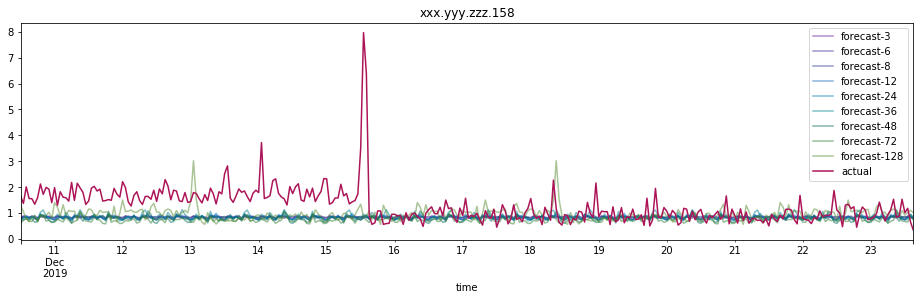

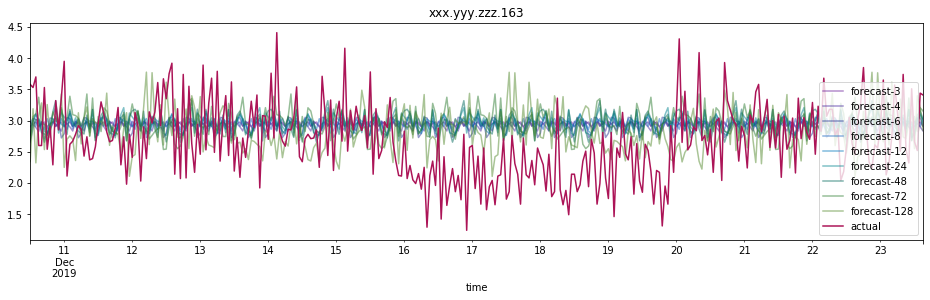

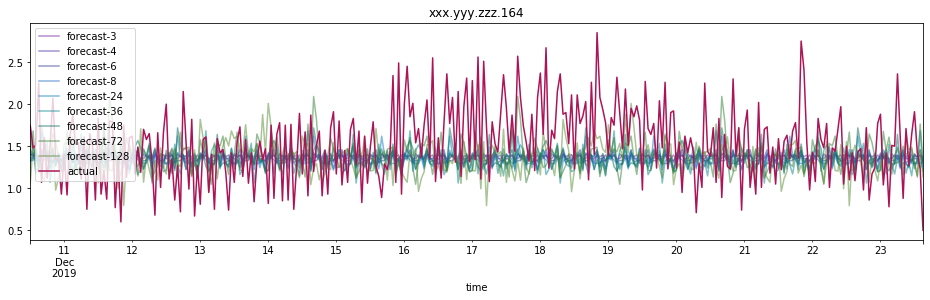

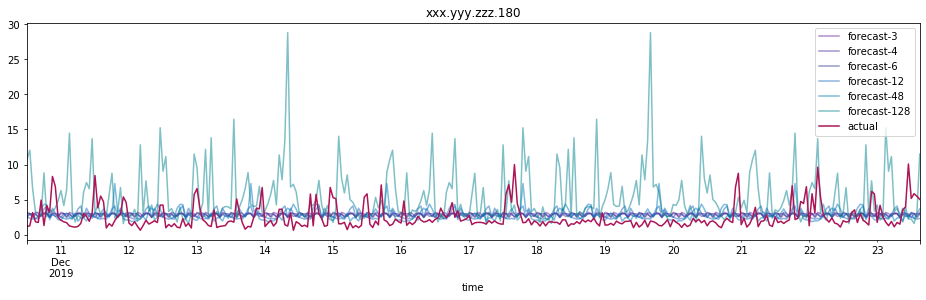

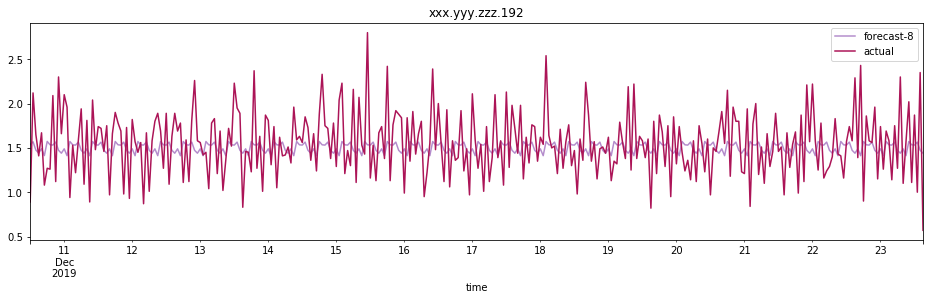

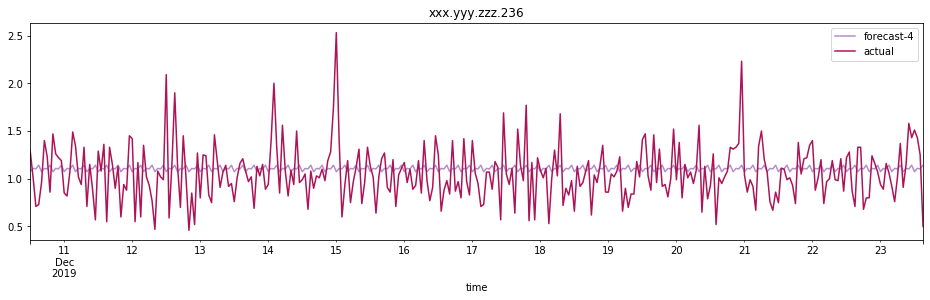

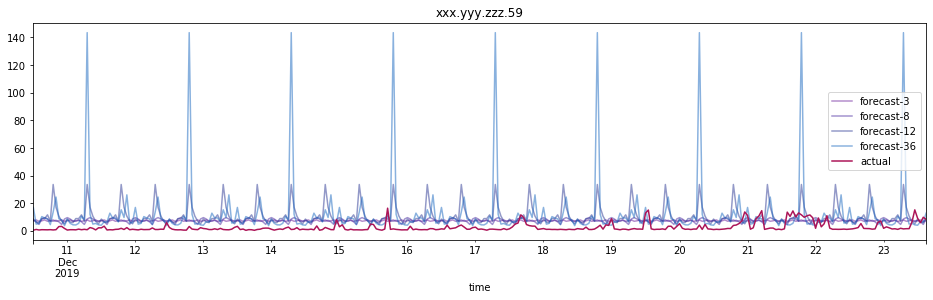

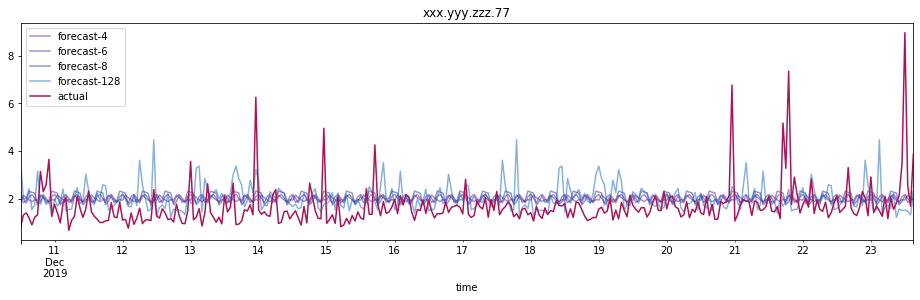

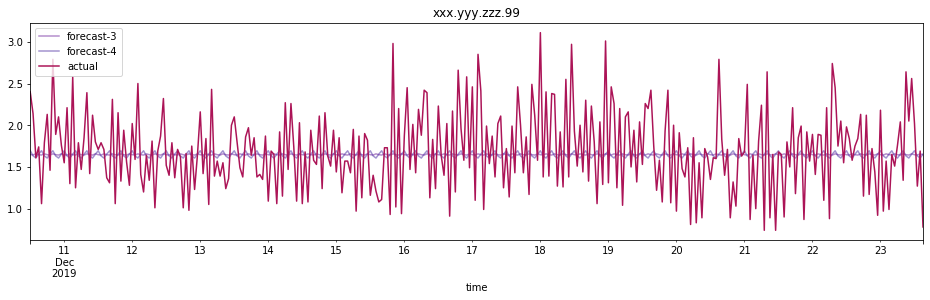

In [37]:
%matplotlib inline

palette_fit = [
    rgba('#6A1B9A'), rgba('#4527A0'), rgba('#283593'), rgba('#1565C0'),
    rgba('#0277BD'), rgba('#00838F'), rgba('#00695C'), rgba('#2E7D32'),
    rgba('#558B2F'), rgba('#9E9D24'), rgba('#F9A825'), rgba('#FF8F00'),
    rgba('#EF6C00'), rgba('#D84315'), rgba('#C62828'), rgba('#4E342E'),
]
palette_key = rgba('#AD1457', alpha=1.0)

period_hour = 4
period_num = 12

uniform_periods = np.linspace(period_hour, period_hour * period_num, period_num)
specific_periods = [3, 4, 6, 8, 12, 24, 36, 48, 72, 128, 168]

tf = pd.DataFrame(data=tload, copy=True)
for row in tf:
    fload = tf[row]
    vals = np.array(fload.to_numpy(np.float64).flat)
    
    print(f'Fitting trends for {fload.name}...')
    fss = []
    for period in specific_periods:
        try:
            ip = int(period)
            print(f'{ip} hours;', end=' ')
            fit = ExponentialSmoothing(
                vals, trend='add', seasonal='add', seasonal_periods=ip, damped=True
            ).fit(use_boxcox=True)
            forecast = fit.forecast(len(fload))
            
            if not np.isnan(forecast[0]):
                fss.append(pd.Series(forecast, name=f'forecast-{ip}', index=fload.index))
        except:
            print(f'error at {ip};', end=' ')
    
    print()
    print(f'Plotting {fload.name}')
    
    alphas = [0.2] * len(fss)
    alphas.append(1.0)
    
    colors = palette_fit[0:len(fss)]
    colors.append(palette_key)
    
    overall = pd.concat([*fss, fload], axis=1).rename(columns={fload.name: "actual"})    
    overall.plot.line(title=fload.name, color=colors, figsize=(16, 4))